In [7]:
# ----------------- 0. Imports & settings -----------------
import os, json, random, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.metrics import pairwise_distances_argmin_min

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
warnings.filterwarnings("ignore")

INPUT_PATH = "/mnt/data/wine.csv"
OUT_DIR = "/mnt/data/wine_analysis_output"
os.makedirs(OUT_DIR, exist_ok=True)

In [8]:
# ----------------- Task 1: EDA -----------------
print("TASK 1: Exploratory Data Analysis (EDA)")
df = pd.read_csv('wine.csv')
print("Loaded:", INPUT_PATH)
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())

# 1.1: Quick head / info / describe
print("\nFirst 5 rows:")
print(df.head().to_string(index=False))
print("\nInfo:")
print(df.info())
print("\nDescribe (numeric):")
print(df.describe().T)

TASK 1: Exploratory Data Analysis (EDA)
Loaded: /mnt/data/wine.csv
Shape: (178, 14)
Columns: ['Type', 'Alcohol', 'Malic', 'Ash', 'Alcalinity', 'Magnesium', 'Phenols', 'Flavanoids', 'Nonflavanoids', 'Proanthocyanins', 'Color', 'Hue', 'Dilution', 'Proline']

First 5 rows:
 Type  Alcohol  Malic  Ash  Alcalinity  Magnesium  Phenols  Flavanoids  Nonflavanoids  Proanthocyanins  Color  Hue  Dilution  Proline
    1    14.23   1.71 2.43        15.6        127     2.80        3.06           0.28             2.29   5.64 1.04      3.92     1065
    1    13.20   1.78 2.14        11.2        100     2.65        2.76           0.26             1.28   4.38 1.05      3.40     1050
    1    13.16   2.36 2.67        18.6        101     2.80        3.24           0.30             2.81   5.68 1.03      3.17     1185
    1    14.37   1.95 2.50        16.8        113     3.85        3.49           0.24             2.18   7.80 0.86      3.45     1480
    1    13.24   2.59 2.87        21.0        118     2.80 

In [9]:
# Save basic summary to JSON
summary = {
    "shape": df.shape,
    "columns": df.columns.tolist(),
    "dtypes": df.dtypes.astype(str).to_dict(),
    "describe": df.describe().to_dict()
}
with open(os.path.join(OUT_DIR, "basic_summary.json"), "w") as f:
    json.dump(summary, f, indent=2)


In [10]:
# 1.2: Missing values
missing = df.isna().sum()
print("\nMissing values per column:")
print(missing)
missing.to_csv(os.path.join(OUT_DIR, "missing_values.csv"))

# 1.3: Histograms / density plots (numeric columns)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print("\nNumeric columns used for plotting:", num_cols)

plt.figure(figsize=(12, 8))
df[num_cols].hist(bins=20, figsize=(12, 10))
plt.suptitle("Histograms of numeric features")
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig(os.path.join(OUT_DIR, "histograms.png"))
plt.close()


Missing values per column:
Type               0
Alcohol            0
Malic              0
Ash                0
Alcalinity         0
Magnesium          0
Phenols            0
Flavanoids         0
Nonflavanoids      0
Proanthocyanins    0
Color              0
Hue                0
Dilution           0
Proline            0
dtype: int64

Numeric columns used for plotting: ['Type', 'Alcohol', 'Malic', 'Ash', 'Alcalinity', 'Magnesium', 'Phenols', 'Flavanoids', 'Nonflavanoids', 'Proanthocyanins', 'Color', 'Hue', 'Dilution', 'Proline']


<Figure size 1200x800 with 0 Axes>


Numeric columns used for plotting: ['Type', 'Alcohol', 'Malic', 'Ash', 'Alcalinity', 'Magnesium', 'Phenols', 'Flavanoids', 'Nonflavanoids', 'Proanthocyanins', 'Color', 'Hue', 'Dilution', 'Proline']


<Figure size 1200x800 with 0 Axes>

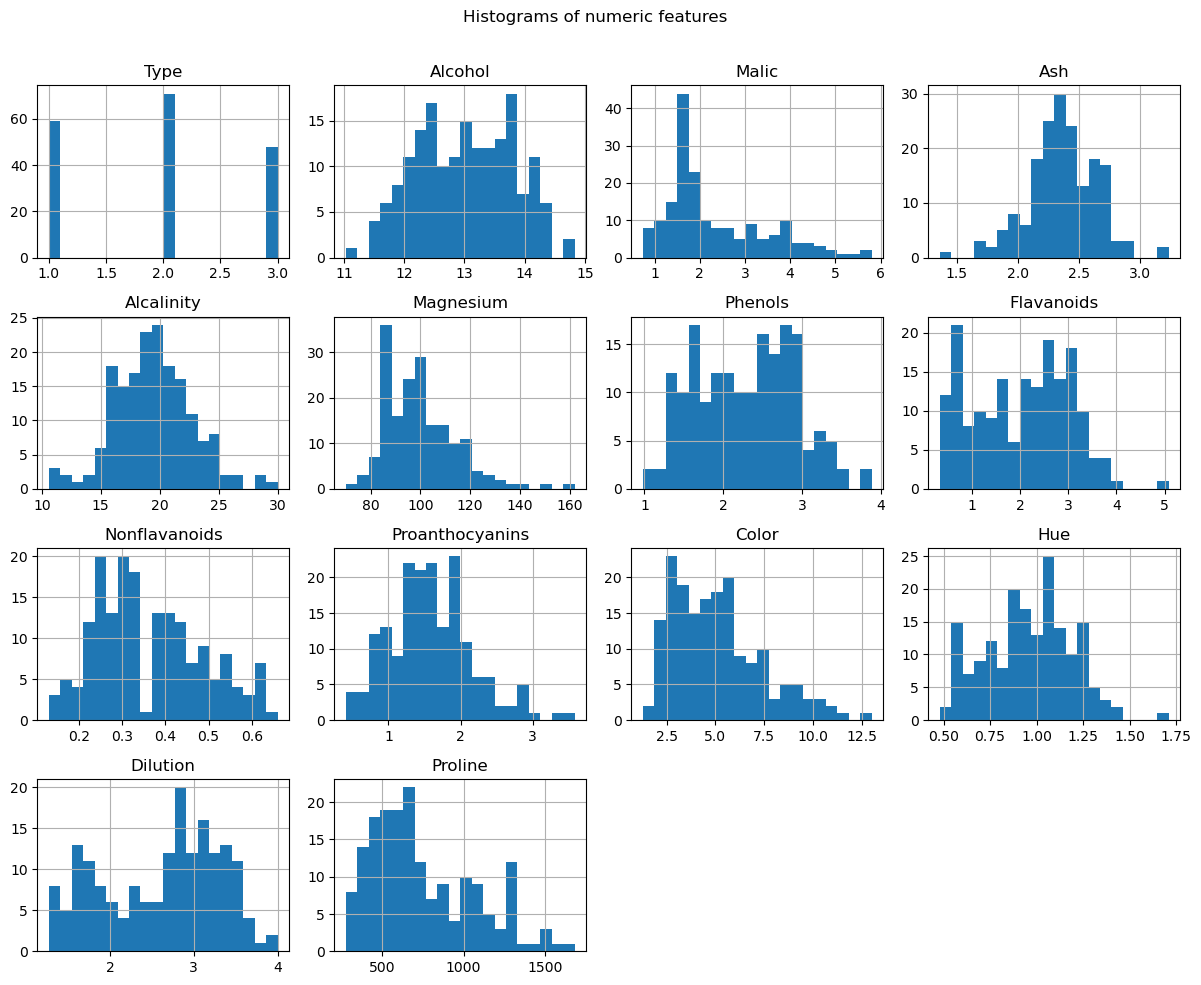

In [11]:
 #1.3: Histograms / density plots (numeric columns)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print("\nNumeric columns used for plotting:", num_cols)

plt.figure(figsize=(12, 8))
df[num_cols].hist(bins=20, figsize=(12, 10))
plt.suptitle("Histograms of numeric features")
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig(os.path.join(OUT_DIR, "histograms.png"))
plt.show()
plt.close()

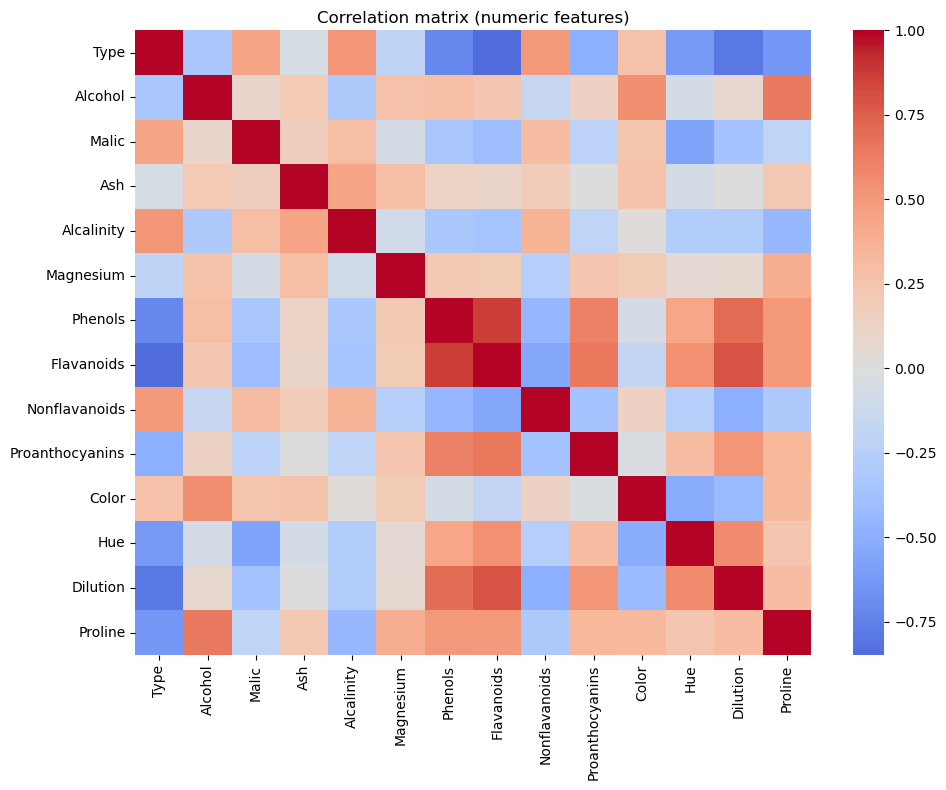

In [12]:
# Pairwise correlation heatmap (use a correlation for numeric features)
corr = df[num_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=False, cmap='coolwarm', center=0)
plt.title("Correlation matrix (numeric features)")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "correlation_heatmap.png"))
plt.show()
plt.close()
corr.to_csv(os.path.join(OUT_DIR, "correlation_matrix.csv"))

In [13]:
# ----------------- Data cleaning before PCA/clustering -----------------
# If target label column exists (like 'target' or 'Class'), drop it for unsupervised tasks
# Try to detect common class columns and keep a copy
possible_label_cols = [c for c in df.columns if c.lower() in ('target', 'class', 'label')]
label_col = possible_label_cols[0] if possible_label_cols else None
if label_col:
    print("Detected label column (will be excluded from unsupervised analysis):", label_col)
    labels = df[label_col].copy()
    data = df.drop(columns=[label_col]).select_dtypes(include=[np.number]).copy()
else:
    labels = None
    data = df.select_dtypes(include=[np.number]).copy()

In [14]:
# Impute missing numeric values with median
imputer = SimpleImputer(strategy="median")
data_imputed = pd.DataFrame(imputer.fit_transform(data), columns=data.columns, index=data.index)

# Save cleaned numeric data
data_imputed.to_csv(os.path.join(OUT_DIR, "data_numeric_cleaned.csv"), index=False)

In [15]:
# ----------------- Task 2: PCA (standardize -> PCA) -----------------
print("\nTASK 2: PCA")
# 2.1 Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data_imputed)

# Save scaler mean/var
np.savez(os.path.join(OUT_DIR, "scaler_stats.npz"), mean=scaler.mean_, var=scaler.var_)


TASK 2: PCA


In [16]:
# 2.2 Fit PCA (retain all components first)
pca = PCA(n_components=min(X_scaled.shape[0], X_scaled.shape[1]), random_state=SEED)
pca.fit(X_scaled)
explained = pca.explained_variance_ratio_
cum_explained = np.cumsum(explained)

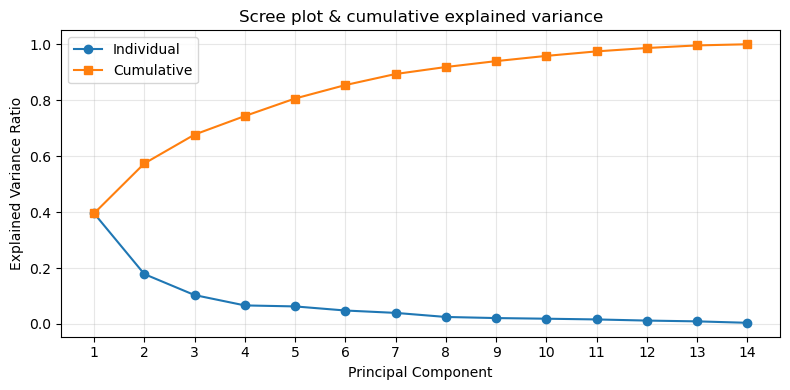

In [17]:
# Scree plot & cumulative explained variance
plt.figure(figsize=(8,4))
plt.plot(np.arange(1, len(explained)+1), explained, marker='o', label='Individual')
plt.plot(np.arange(1, len(cum_explained)+1), cum_explained, marker='s', label='Cumulative')
plt.xticks(np.arange(1, len(explained)+1))
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.title("Scree plot & cumulative explained variance")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "pca_scree_cumulative.png"))
plt.show()
plt.close()


In [18]:
# Determine number of components to explain e.g. 90% variance (you can change threshold)
threshold = 0.90
n_components_90 = int(np.searchsorted(cum_explained, threshold) + 1)
print(f"Number of components to explain >= {threshold*100:.0f}% variance: {n_components_90}")


Number of components to explain >= 90% variance: 8


In [19]:

# Save explained variance info
pd.DataFrame({
    "pc_index": np.arange(1, len(explained)+1),
    "explained_variance_ratio": explained,
    "cumulative_explained": cum_explained
}).to_csv(os.path.join(OUT_DIR, "pca_explained_variance.csv"), index=False)

In [20]:

# 2.3 Transform dataset into principal components using an optimal number (use n_components_90)
pca_k = PCA(n_components=n_components_90, random_state=SEED)
X_pca = pca_k.fit_transform(X_scaled)
df_pca = pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(X_pca.shape[1])], index=data_imputed.index)
df_pca.to_csv(os.path.join(OUT_DIR, f"data_pca_{n_components_90}components.csv"), index=False)


In [21]:
# ----------------- Task 3: Clustering on Original Data -----------------
print("\nTASK 3: Clustering on original (standardized) data")
# Choose k: try a range and evaluate silhouette and DB index to pick best k
k_range = range(2, 8)  # adjust as needed
kmeans_results_orig = {}
for k in k_range:
    km = KMeans(n_clusters=k, random_state=SEED, n_init=10)
    preds = km.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, preds)
    db = davies_bouldin_score(X_scaled, preds)
    inertia = km.inertia_
    kmeans_results_orig[k] = {"silhouette": float(sil), "davies_bouldin": float(db), "inertia": float(inertia)}
    print(f"k={k}: silhouette={sil:.4f}, db={db:.4f}, inertia={inertia:.2f}")

# Save metrics
with open(os.path.join(OUT_DIR, "kmeans_orig_metrics.json"), "w") as f:
    json.dump(kmeans_results_orig, f, indent=2)
# Choose best k by silhouette (max) for original data
best_k_orig = max(kmeans_results_orig.items(), key=lambda x: x[1]['silhouette'])[0]
print("Best k (original data) by silhouette:", best_k_orig)

# Fit final KMeans for original data
kmeans_orig = KMeans(n_clusters=best_k_orig, random_state=SEED, n_init=50)
labels_orig = kmeans_orig.fit_predict(X_scaled)
# Save cluster centers (in scaled space) and labels
np.savez(os.path.join(OUT_DIR, "kmeans_orig_n{}_centers.npz".format(best_k_orig)), centers=kmeans_orig.cluster_centers_)
pd.Series(labels_orig, name="cluster_orig").to_csv(os.path.join(OUT_DIR, "cluster_labels_orig.csv"), index=False)

# Visualize clustering using first two PCA components for plotting
# If PCA already computed, use first two PCs (from pca_k or full pca)
if df_pca.shape[1] >= 2:
    plt.figure(figsize=(8,6))
    scatter = plt.scatter(df_pca["PC1"], df_pca["PC2"], c=labels_orig, cmap='tab10', s=30, alpha=0.8)
    plt.xlabel("PC1"); plt.ylabel("PC2"); plt.title(f"KMeans (original data) visualized on first 2 PCs, k={best_k_orig}")
    plt.colorbar(scatter, label='cluster')
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, f"kmeans_orig_on_pca12_k{best_k_orig}.png"))
    plt.close()


TASK 3: Clustering on original (standardized) data


  File "C:\Users\saksh\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "C:\Users\saksh\anaconda3\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\saksh\anaconda3\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
                        pass_fds, cwd, env,
                        ^^^^^^^^^^^^^^^^^^^
    ...<5 lines>...
                        gid, gids, uid, umask,
                        ^^^^^^^^^^^^^^^^^^^^^^
                        start_new_session, process_group)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\saksh\anaconda3\Lib\subprocess.

k=2: silhouette=0.2862, db=1.3697, inertia=1727.23
k=3: silhouette=0.3077, db=1.3164, inertia=1285.56
k=4: silhouette=0.2712, db=1.7826, inertia=1182.95
k=5: silhouette=0.2517, db=1.7418, inertia=1114.51
k=6: silhouette=0.2604, db=1.5007, inertia=1051.78
k=7: silhouette=0.1428, db=1.9489, inertia=1011.77
Best k (original data) by silhouette: 3


In [22]:
print("\nTASK 4: Clustering on PCA-transformed data")
kmeans_results_pca = {}
# Try same k range (or narrower)
for k in k_range:
    km = KMeans(n_clusters=k, random_state=SEED, n_init=10)
    preds = km.fit_predict(X_pca)
    sil = silhouette_score(X_pca, preds)
    db = davies_bouldin_score(X_pca, preds)
    inertia = km.inertia_
    kmeans_results_pca[k] = {"silhouette": float(sil), "davies_bouldin": float(db), "inertia": float(inertia)}
    print(f"[PCA] k={k}: silhouette={sil:.4f}, db={db:.4f}, inertia={inertia:.2f}")

with open(os.path.join(OUT_DIR, "kmeans_pca_metrics.json"), "w") as f:
    json.dump(kmeans_results_pca, f, indent=2)

# Best k by silhouette for PCA data
best_k_pca = max(kmeans_results_pca.items(), key=lambda x: x[1]['silhouette'])[0]
print("Best k (PCA data) by silhouette:", best_k_pca)

# Fit final KMeans for PCA data
kmeans_pca = KMeans(n_clusters=best_k_pca, random_state=SEED, n_init=50)
labels_pca = kmeans_pca.fit_predict(X_pca)
pd.Series(labels_pca, name="cluster_pca").to_csv(os.path.join(OUT_DIR, "cluster_labels_pca.csv"), index=False)
np.savez(os.path.join(OUT_DIR, f"kmeans_pca_n{best_k_pca}_centers.npz"), centers=kmeans_pca.cluster_centers_)
# Visualize PCA clustering in PC1 vs PC2
plt.figure(figsize=(8,6))
scatter = plt.scatter(df_pca["PC1"], df_pca["PC2"], c=labels_pca, cmap='tab10', s=30, alpha=0.8)
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.title(f"KMeans on PCA data (k={best_k_pca})")
plt.colorbar(scatter, label='cluster')
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, f"kmeans_pca_pc1_pc2_k{best_k_pca}.png"))
plt.close()



TASK 4: Clustering on PCA-transformed data
[PCA] k=2: silhouette=0.3125, db=1.2756, inertia=1524.75
[PCA] k=3: silhouette=0.3402, db=1.1903, inertia=1084.66
[PCA] k=4: silhouette=0.2920, db=1.5694, inertia=990.94
[PCA] k=5: silhouette=0.3021, db=1.4857, inertia=918.77
[PCA] k=6: silhouette=0.2276, db=1.5227, inertia=866.94
[PCA] k=7: silhouette=0.1737, db=1.7512, inertia=812.01
Best k (PCA data) by silhouette: 3


In [23]:
print("\nTASK 5: Compare clustering results (original vs PCA)")

# Simple contingency table between cluster assignments
contingency = pd.crosstab(pd.Series(labels_orig, name="orig"), pd.Series(labels_pca, name="pca"))
contingency.to_csv(os.path.join(OUT_DIR, "cluster_contingency_orig_vs_pca.csv"))
print("Contingency table saved.")

# Compare silhouette and DB indices for chosen best clusters
metrics_compare = {
    "orig": {
        "k": int(best_k_orig),
        "silhouette": float(silhouette_score(X_scaled, labels_orig)),
        "davies_bouldin": float(davies_bouldin_score(X_scaled, labels_orig))
    },
    "pca": {
        "k": int(best_k_pca),
        "silhouette": float(silhouette_score(X_pca, labels_pca)),
        "davies_bouldin": float(davies_bouldin_score(X_pca, labels_pca))
    }
}
with open(os.path.join(OUT_DIR, "clustering_comparison_metrics.json"), "w") as f:
    json.dump(metrics_compare, f, indent=2)
print("Comparison metrics saved:", metrics_compare)

# Find representative points: closest point to each cluster center (in original and PCA spaces)
closest_orig, _ = pairwise_distances_argmin_min(kmeans_orig.cluster_centers_, X_scaled)
closest_pca, _ = pairwise_distances_argmin_min(kmeans_pca.cluster_centers_, X_pca)
rep_orig_idx = list(closest_orig)
rep_pca_idx = list(closest_pca)
pd.DataFrame({"rep_orig_index": rep_orig_idx, "rep_pca_index": rep_pca_idx}).to_csv(os.path.join(OUT_DIR, "representative_indices.csv"), index=False)




TASK 5: Compare clustering results (original vs PCA)
Contingency table saved.
Comparison metrics saved: {'orig': {'k': 3, 'silhouette': 0.30773604383565206, 'davies_bouldin': 1.3163957434114109}, 'pca': {'k': 3, 'silhouette': 0.3402428666857788, 'davies_bouldin': 1.1903042789637739}}


In [24]:
print("\nTASK 6: Generating conclusions & insights (saved to text file)")
insights = []
insights.append("Summary of steps performed:")
insights.append(f"- Dataset loaded with shape {df.shape}; numeric features used: {len(num_cols)}")
insights.append(f"- Missing values imputed by median; standardized features before PCA/clustering.")
insights.append(f"- PCA: {n_components_90} components explain >= {threshold*100:.0f}% variance.")
insights.append(f"- Clustering (KMeans) on original data: best k (by silhouette) = {best_k_orig}.")
insights.append(f"- Clustering on PCA-transformed data: best k (by silhouette) = {best_k_pca}.")
insights.append(f"- Clustering metrics (orig vs pca) saved in 'clustering_comparison_metrics.json'.")
insights.append("Practical observations to consider:")
insights.append("- PCA reduces dimensionality and often improves clustering speed and noise reduction.")
insights.append("- If silhouette (PCA) > silhouette (orig), PCA improved cluster separability; compare DB index similarly.")
insights.append("- Use contingency table to inspect how clusters map between original and PCA clustering.")
insights.append("- Examine representative indices to inspect actual records that are closest to cluster centers.")
insights.append("\nRecommendations:")
insights.append("- Use PCA when dataset is high-dimensional or contains multicollinearity; it helps reduce noise.")
insights.append("- For interpretability, clustering on original features may be preferred; for speed/noise reduction, use PCA.")
insights.append("- Try alternative clustering methods (Agglomerative, DBSCAN, GaussianMixture) to validate findings.")
insights.append("- Consider domain knowledge when choosing #clusters; evaluation metrics are guides but not absolute.")

with open(os.path.join(OUT_DIR, "insights_and_conclusions.txt"), "w") as f:
    f.write("\n".join(insights))

print("All outputs and plots saved to:", OUT_DIR)
print("Done.")


TASK 6: Generating conclusions & insights (saved to text file)
All outputs and plots saved to: /mnt/data/wine_analysis_output
Done.
